In [118]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import functions.eddy_feedback as ef

In [119]:
directory_path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/')

# Initialize an empty list to store the model names
model_names = []
# Iterate through the files in the directory
for file in directory_path.iterdir():
    if file.is_file() and file.suffix == ".nc":
        # Extract the stem (filename without extension)
        filename_stem = file.stem
        # Split by underscore and take the first part (MODEL)
        model_name = filename_stem.split('_')[0]
        # Append the model name to the list
        model_names.append(model_name)
        
# sort the models alphabetically
model_names.sort()
model_names.remove('E3SMv1')
model_names.remove('ECHAM6.3')
model_names

['CESM1-WACCM-SC',
 'CESM2',
 'CNRM-CM6-1',
 'CanESM5',
 'EC-EARTH3',
 'FGOALS-f3-L',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IPSL-CM6A-LR',
 'MIROC6',
 'NorESM2-LM',
 'OpenIFS-159',
 'OpenIFS-511']

In [120]:
ds_models = {}
for model in model_names:
    
    # set file directory
    file_dir = directory_path.glob(f'{model}*.nc')
    # import data
    dataset = xr.open_mfdataset(
        file_dir,
        parallel=True
    )
    
    # subset data
    dataset = dataset.where(dataset.level < 1000.)
    dataset = dataset.where(dataset.lat < 90.)
    
    # save to dictionary
    ds_models[model] = dataset
    
# del ds_models['E3SMv1']
# del ds_models['ECHAM6.3']
len(ds_models)

13

In [142]:
model_efp_res = {}
for model in model_names:
    
    # calculate EFP
    efp = ef.calculate_efp(ds_models[model], data_type='pamip')
    
    # calculate each model res
    resolution = abs(ds_models[model].lat[0] - ds_models[model].lat[1])
    
    model_efp_res[model] = (efp, resolution.values.item())
    
del model_efp_res['CESM1-WACCM-SC']
# del model_efp_res['CanESM5']
# del model_efp_res['NorESM2-LM']


In [143]:
efp = []
res = []
for model in model_efp_res:
    
    efp.append(model_efp_res[model][0])
    res.append(model_efp_res[model][1])
print(efp)
print(res)

[0.3782, 0.2469, 0.4314, 0.3003, 0.2395, 0.278, 0.3166, 0.2762, 0.2216, 0.3294, 0.3328, 0.2325]
[0.9424083769633569, 1.3890301392673479, 2.7672718509152787, 0.6958699999999993, 1.0, 1.25, 0.5555572509765625, 1.267608642578125, 1.3890301392687405, 1.8947368421052602, 1.125, 1.125]


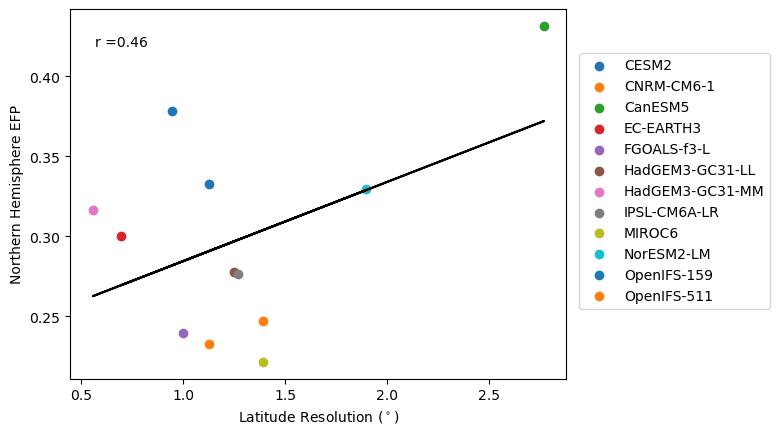

In [144]:
plt.figure()

for model in model_efp_res:
    plt.scatter(model_efp_res[model][1], model_efp_res[model][0], label=model)
    
# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=res, y=efp)
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)
coef = np.polyfit(res,efp,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(res, poly1d_fn(res), 'k')

plt.xlabel('Latitude Resolution ($^\\circ$)')
plt.ylabel('Northern Hemisphere EFP')
plt.legend(loc='upper right', bbox_to_anchor=(1.425, 0.9))
plt.show()

# Seaborn plot

In [145]:
# Convert to DataFrame
df = pd.DataFrame([
    {"Model": model, "EFP Value": values[0], "Latitude Resolution": values[1]} 
    for model, values in model_efp_res.items()
])
df

# new_rows = {
#     'Model': ['E3SMv1', 'ECHAM6.3'],
#     'EFP Value': [0.05, 0.37],
#     'Latitude Resolution': [1, 0.94]
# }
# new_rows = {
#     'Model': ['ECHAM6.3'],
#     'EFP Value': [0.37],
#     'Latitude Resolution': [0.94]
# }

# new_pd = pd.DataFrame(new_rows)
# df = pd.concat([df, new_pd], ignore_index=True)
# df

,Model,EFP Value,Latitude Resolution
0,CESM2,0.3782,0.942408
1,CNRM-CM6-1,0.2469,1.389030
2,CanESM5,0.4314,2.767272
3,EC-EARTH3,0.3003,0.695870
4,FGOALS-f3-L,0.2395,1.000000
5,HadGEM3-GC31-LL,0.2780,1.250000
6,HadGEM3-GC31-MM,0.3166,0.555557
7,IPSL-CM6A-LR,0.2762,1.267609
8,MIROC6,0.2216,1.389030
9,NorESM2-LM,0.3294,1.894737


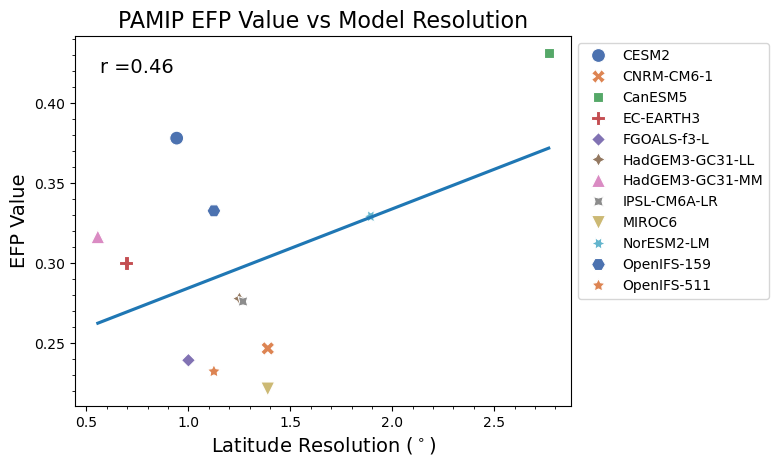

In [147]:
plt.figure()
# sns.regplot(data=df, x='Latitude Resolution', y='EFP Value', scatter_kws={'color': 'white'}, line_kws={"color": "gray"})
scatter_plot = sns.scatterplot(
    x='Latitude Resolution', 
    y='EFP Value', 
    hue='Model', 
    style='Model', 
    data=df, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='Latitude Resolution', 
    y='EFP Value', 
    data=df, 
    scatter=False, 
    ax=scatter_plot,
    ci=None
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['Latitude Resolution'], y=df['EFP Value'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, fontsize=14)

ax.set_xlabel('Latitude Resolution ($^\\circ$)', fontsize=14)
ax.set_ylabel('EFP Value', fontsize=14)   
ax.set_title('PAMIP EFP Value vs Model Resolution', fontsize=16)

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()